# PGAM col_mask demo: bat on an island

A bat flies freely on a small island sitting inside a larger 10×10 m square.
The recording arena covers the whole square, but the animal only visits a
compact sub-region.  A 2-D B-spline basis built on the full square therefore
has many columns that are never activated — wasting parameters and causing
near-singular penalty matrices.

This notebook shows how to:

1. Detect the unused columns with `get_active_col_mask()`.
2. Fit a Poisson PGAM on the **reduced** (masked) basis.
3. Reconstruct the full 2-D tuning map — including the unvisited region —
   from the masked fit, using `eval_basis` on a dense grid.

In [23]:
import numpy as np
import scipy.stats as sts
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Circle

from PGAM.gam_data_handlers import smooths_handler
from PGAM.GAM_library import general_additive_model

## 1. Simulate bat trajectory on the island

The "island" is a circle of radius 2.5 m centred at (6, 5) inside a
10×10 m square.  We draw 8 000 random positions uniformly from that disc.

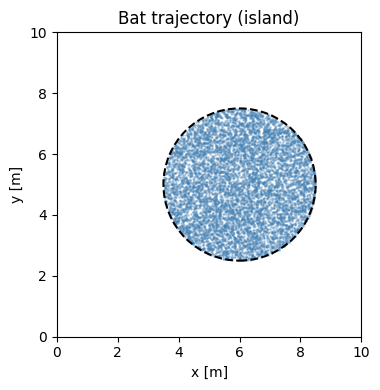

In [24]:
rng = np.random.default_rng(42)

# island geometry
SQUARE   = 10.0          # arena side length [m]
ISLAND_C = np.array([6.0, 5.0])   # centre of the island
ISLAND_R = 2.5           # radius [m]
N_POS    = 8_000         # number of recorded positions

# sample uniformly from the disc
r     = ISLAND_R * np.sqrt(rng.uniform(0, 1, N_POS))
theta = rng.uniform(0, 2 * np.pi, N_POS)
x_bat = ISLAND_C[0] + r * np.cos(theta)
y_bat = ISLAND_C[1] + r * np.sin(theta)

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(x_bat, y_bat, s=1, alpha=0.3, color='steelblue')
circle = Circle(ISLAND_C, ISLAND_R, fill=False, color='k', lw=1.5, ls='--')
ax.add_patch(circle)
ax.set_xlim(0, SQUARE); ax.set_ylim(0, SQUARE)
ax.set_aspect('equal'); ax.set_title('Bat trajectory (island)')
ax.set_xlabel('x [m]'); ax.set_ylabel('y [m]')
plt.tight_layout()
plt.show()

## 2. Build the 2-D basis and measure sparsity

We use a 7×7 interior knot grid over the whole square.
Most Kronecker-product columns receive **zero** observations.

In [ ]:
KNOTS_NUM = 15
k1d   = np.linspace(0, SQUARE, KNOTS_NUM)
knots = [k1d, k1d]

sm_handler_full = smooths_handler()
sm_handler_full.add_smooth(
    'pos',
    [x_bat, y_bat],
    knots=knots,
    is_cyclic=np.array([False, False]),
    penalty_type='EqSpaced',
)

smooth_full = sm_handler_full['pos']
n_cols_full = smooth_full.X.shape[1] - 1   # active columns (excl. intercept)
mask        = smooth_full.get_active_col_mask()
n_active    = mask.sum()

print(f'Full basis columns  : {n_cols_full}')
print(f'Active columns      : {n_active}  ({100*n_active/n_cols_full:.0f} %)')
print(f'Dropped (zero-obs)  : {n_cols_full - n_active}')

In [ ]:
# visualise which 2-D grid cells are active
# X has n_side² columns (Kronecker product); the mask covers all but the last.
# Restore the last (always-kept) column to make the count a perfect square,
# then reshape into a 2-D grid.
n_side      = int(round(np.sqrt(smooth_full.X.shape[1])))
mask_for_vis = np.append(mask, True)          # re-add the always-kept last col
# reshape: row index = x-basis index, col index = y-basis index
# (multiRowWiseKron orders as ix * n_side + iy, so first index is x)
# transpose before imshow so x maps to horizontal and y to vertical
active_grid  = mask_for_vis.reshape(n_side, n_side).T

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(active_grid, origin='lower', extent=[0, SQUARE, 0, SQUARE],
          cmap='Greens', vmin=0, vmax=1, aspect='equal')
circle = Circle(ISLAND_C, ISLAND_R, fill=False, color='r', lw=1.5, ls='--')
ax.add_patch(circle)
ax.set_title(f'Active basis cells\n({n_active}/{n_cols_full} = '
             f'{100*n_active/n_cols_full:.0f} %)')
ax.set_xlabel('x [m]'); ax.set_ylabel('y [m]')
plt.tight_layout()
plt.show()

The **top-right corner cell is always shown as active** even if no data fell there.
This is intentional: internally the implementation always keeps the very last
column of X (the product of the last x-basis function and the last y-basis
function) so that `additive_model_preprocessing`'s `X[:, :-1]` slice —
which is used throughout the fitting and prediction pipeline for identifiability
— continues to work without any modification.
That corner column is carried along silently and dropped before the beta
coefficients are estimated; it never influences the fit.


## 3. Simulate a known 2-D tuning function

The "true" log-rate is a 2-D Gaussian bump near the centre of the island.
Spike counts are drawn from a Poisson distribution.

In [ ]:
# true log-rate: Gaussian bump centred on the island
PEAK_LOG_RATE = 2.0    # log(Hz * bin_size) at the peak
SIGMA_TUNING  = 1.5    # width [m]
MEAN_LOG_RATE = -1.5   # background (intercept)

peak_centre = np.array([5.5, 5.0])
log_rate_true = (
    MEAN_LOG_RATE
    + PEAK_LOG_RATE * np.exp(
        -0.5 * (
            ((x_bat - peak_centre[0]) / SIGMA_TUNING) ** 2
            + ((y_bat - peak_centre[1]) / SIGMA_TUNING) ** 2
        )
    )
)

spike_counts = rng.poisson(np.exp(log_rate_true))
print(f'Mean spike count per bin: {spike_counts.mean():.3f}')

## 4. Fit the model with the col_mask

We rebuild `sm_handler` passing the mask so that X and the penalty matrices
are automatically reduced before fitting.

In [ ]:
sm_handler = smooths_handler()
sm_handler.add_smooth(
    'pos',
    [x_bat, y_bat],
    knots=knots,
    is_cyclic=np.array([False, False]),
    penalty_type='EqSpaced',
    col_mask=mask,
)

print(f'Masked X shape: {sm_handler["pos"].X.shape}   '
      f'(was {smooth_full.X.shape})')

family = sm.families.Poisson()
gam    = general_additive_model(sm_handler, ['pos'], spike_counts, family)
result = gam.optim_gam(['pos'], max_iter=200)

print(f'\nFit converged.  Pseudo-R²: {result.pseudo_r2:.3f}')
print(f'Smoothing parameter (log): {np.log(result.smooth_pen[0]):.2f}')

## 5. Reconstruct the full 2-D tuning map

`eval_basis` applies the stored mask automatically, so we get a basis matrix
with the correct width for the fitted beta.  We evaluate on a dense grid
covering the **whole** square — the smooth naturally extrapolates into the
unvisited region.

In [ ]:
GRID_N   = 80
xg       = np.linspace(0, SQUARE, GRID_N)
yg       = np.linspace(0, SQUARE, GRID_N)
xg_mesh, yg_mesh = np.meshgrid(xg, yg)   # (GRID_N, GRID_N)

xg_flat  = xg_mesh.ravel()
yg_flat  = yg_mesh.ravel()

# eval_basis handles masking internally and returns shape (n_pts, n_masked+1)
fX = result.eval_basis([xg_flat, yg_flat], 'pos', sparseX=False)

# apply the same centering that smooth_compute uses (subtract training means)
colMean  = result.smooth_info['pos']['colMean_X']   # shape (n_active,)
fX_cent  = fX[:, :-1] - colMean                    # drop last col, centre

# select the beta coefficients for this smooth
index    = result.index_dict['pos']
log_rate_map = fX_cent @ result.beta[index]         # shape (GRID_N**2,)
log_rate_map = log_rate_map.reshape(GRID_N, GRID_N)

In [ ]:
# ---- plot the reconstruction ------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(13, 4))

# (a) true log-rate on the training positions
sc = axes[0].scatter(x_bat, y_bat, c=log_rate_true, s=2,
                     cmap='RdBu_r', vmin=-2, vmax=1)
circle = Circle(ISLAND_C, ISLAND_R, fill=False, color='k', lw=1.5, ls='--')
axes[0].add_patch(circle)
axes[0].set_title('True log-rate\n(training points)')
plt.colorbar(sc, ax=axes[0], shrink=0.8)

# (b) reconstructed log-rate on full grid
vmax = np.abs(log_rate_map).max()
im = axes[1].imshow(log_rate_map, origin='lower',
                    extent=[0, SQUARE, 0, SQUARE],
                    cmap='RdBu_r', vmin=-vmax, vmax=vmax, aspect='equal')
circle = Circle(ISLAND_C, ISLAND_R, fill=False, color='k', lw=1.5, ls='--')
axes[1].add_patch(circle)
axes[1].set_title('Fitted log-rate\n(full grid, masked model)')
plt.colorbar(im, ax=axes[1], shrink=0.8)

# (c) true log-rate on full grid (for comparison)
true_map = (
    MEAN_LOG_RATE
    + PEAK_LOG_RATE * np.exp(
        -0.5 * (
            ((xg_mesh - peak_centre[0]) / SIGMA_TUNING) ** 2
            + ((yg_mesh - peak_centre[1]) / SIGMA_TUNING) ** 2
        )
    )
)
# true map is in absolute log-rate; centre it the same way the fit is centred
# (subtract mean over training points so scales match)
true_map_centred = true_map - log_rate_true.mean()

im2 = axes[2].imshow(true_map_centred, origin='lower',
                     extent=[0, SQUARE, 0, SQUARE],
                     cmap='RdBu_r', vmin=-vmax, vmax=vmax, aspect='equal')
circle = Circle(ISLAND_C, ISLAND_R, fill=False, color='k', lw=1.5, ls='--')
axes[2].add_patch(circle)
axes[2].set_title('True log-rate\n(full grid, centred)')
plt.colorbar(im2, ax=axes[2], shrink=0.8)

for ax in axes:
    ax.set_xlabel('x [m]'); ax.set_ylabel('y [m]')

plt.tight_layout()
plt.show()

## 6. Predicted firing-rate map via `predict`

`smooth_compute` returns a **centred** smooth (zero mean over training data),
useful for comparing tuning shapes across neurons.  `predict` instead returns
the **absolute** expected spike count per sample — intercept included.  For a
Poisson model with log link, `predict(log_space=False)` gives `exp(η)` directly.

In [ ]:
# predict() on the full grid — no manual basis arithmetic needed
mu_counts = result.predict([[xg_flat, yg_flat]], log_space=False)  # counts/sample
mu_counts_map = mu_counts.reshape(GRID_N, GRID_N)

# true expected counts on the same grid (for comparison)
true_counts_map = np.exp(true_map)

fig, axes = plt.subplots(1, 2, figsize=(9, 4))

vmax = max(true_counts_map.max(), mu_counts_map.max())
kw   = dict(origin='lower', extent=[0, SQUARE, 0, SQUARE],
            cmap='hot_r', vmin=0, vmax=vmax, aspect='equal')

im0 = axes[0].imshow(true_counts_map, **kw)
circle = Circle(ISLAND_C, ISLAND_R, fill=False, color='w', lw=1.5, ls='--')
axes[0].add_patch(circle)
axes[0].set_title('True expected counts\n(full grid)')
plt.colorbar(im0, ax=axes[0], shrink=0.8, label='counts / sample')

im1 = axes[1].imshow(mu_counts_map, **kw)
circle = Circle(ISLAND_C, ISLAND_R, fill=False, color='w', lw=1.5, ls='--')
axes[1].add_patch(circle)
axes[1].set_title('predict() — fitted expected counts\n(full grid, masked model)')
plt.colorbar(im1, ax=axes[1], shrink=0.8, label='counts / sample')

for ax in axes:
    ax.set_xlabel('x [m]'); ax.set_ylabel('y [m]')

plt.tight_layout()
plt.show()

Inside the island `predict` closely tracks the truth; outside it the smooth
extrapolates gracefully because the penalty enforces regularity across the whole
domain, not just the visited region.

## 7. Basis reduction summary

The key numbers to communicate to collaborators:

In [ ]:
print('=== Basis reduction summary ===')
print(f'  Full basis size      : {n_cols_full:4d} parameters')
print(f'  Active after masking : {n_active:4d} parameters  '
      f'({100*n_active/n_cols_full:.0f} % of full)')
print(f'  Reduction factor     : {n_cols_full/n_active:.1f}×')
print()
print('The masked fit recovers the tuning function inside the visited region')
print('and extrapolates smoothly outside it — zero extra code needed at')
print('predict time because eval_basis applies the mask automatically.')